In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/EnKF/")

"/media/mat/HDD/EnKF/Project.toml"

In [120]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations

In [121]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
clibrary(:colorbrewer)
pyplot()

┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()

We are interested in simulating the Duffing oscillator with forcing
                $$\frac{d^2 x}{dt^2} = x - x^3 - \gamma \dot{x}   + d cos(\omega t)$$
with $\gamma = 0.1, d = 0.1$ and $\omega = 1.4$

Reference: http://physics.ucsc.edu/~peter/115/duffing.pdf

First, let us solve the dynamical equation using DifferentialEquations.jl with $x₀ = [1.0, -1.0]$ on  $[0.0, 50.0]$ with a RK4 method

We also define an `integrator` that will can propagate our solution from time t to t + Δt 

In [122]:
function duffing(du,u,p,t)
 du[1] = u[2]
 du[2] = u[1] - u[1]^3 -γ*u[2] + d*cos(ω*t)
end

γ = 0.1
d = 0.1
ω = 1.4

u0 = [1.0; -1.0]
tspan = (0.0,50.0)

Δt = 1e-2
T = tspan[1]:Δt:tspan[end]

prob = ODEProblem(duffing, u0, tspan)
sol = solve(prob, RK4(), adaptive = false, dt = Δt)

integrator = init(prob, RK4(), adaptive =false, dt = Δt, save_everystep=false)

t: 0.0
u: 2-element Array{Float64,1}:
  1.0
 -1.0

Plot solution

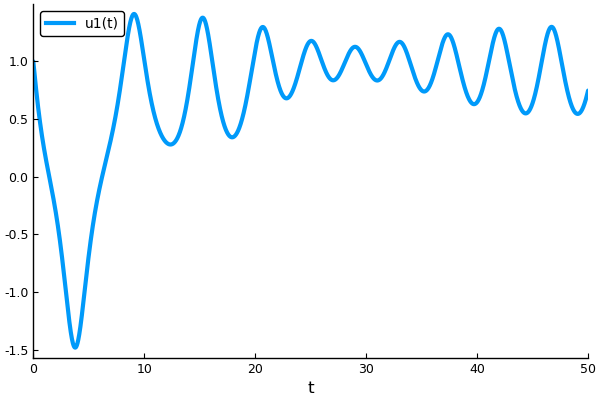

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


In [123]:
plot(sol, vars = (1))

## Tools for the ensemble Kalman filter

The ensemble Kalman filter known under the sobriquet EnKF is a Monte-Carlo view of the Kalman filter suited for large and nonlinear systems introduced by Evensen, et al.(1999)

In [124]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
#         for j=1:10
        step!(integrator)
#         end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [125]:
fprop = PropagationFunction()

PropagationFunction()

Define measurement function m

In [126]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return [s[2]]
end

In [127]:
function (::MeasurementFunction)(t::Float64) 
    return reshape([0.0, 1.0],(1,2))
end

In [128]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z

In [129]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
    fill!(ENS, [deepcopy(s[2])])
    end
    return ENS
end

In [130]:
z = RealMeasurementFunction()

RealMeasurementFunction()

Define covariance inflation

In [131]:
A = MultiAdditiveInflation(2, 1.05, MvNormal(zeros(2), 2.0*I))
# A = IdentityInflation()

MultiAdditiveInflation{2}(1.05, IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [4.0 0.0; 0.0 4.0]
)
)

Define noise covariance

In [132]:
ϵ = AdditiveInflation(MvNormal(zeros(1), 1.0*I))

AdditiveInflation{1}(IsoNormal(
dim: 1
μ: [0.0]
Σ: [1.0]
)
)

In [133]:
N = 50
NZ = 1
isinflated = false
isfiltered = false
isaugmented = false

false

In [134]:
x₀ = [0.5, -0.5]
ens = initialize(N, MvNormal(x₀, 2.0*I))
estimation_state = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]
covs = []

0-element Array{Any,1}

In [135]:
g = FilteringFunction()

FilteringFunction()

In [136]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,1}(PropagationFunction(), MultiAdditiveInflation{2}(1.05, IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [4.0 0.0; 0.0 4.0]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{1}(IsoNormal(
dim: 1
μ: [0.0]
Σ: [1.0]
)
), false, false, false)

### Ensemble Kalman filter estimation

In [137]:
Δt = 1e-2
Tsub = 0.0:Δt:50.0-Δt

for (n,t) in enumerate(Tsub)

    global ens
    
    t, ens, cov = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    push!(covs, deepcopy(cov))
    

end

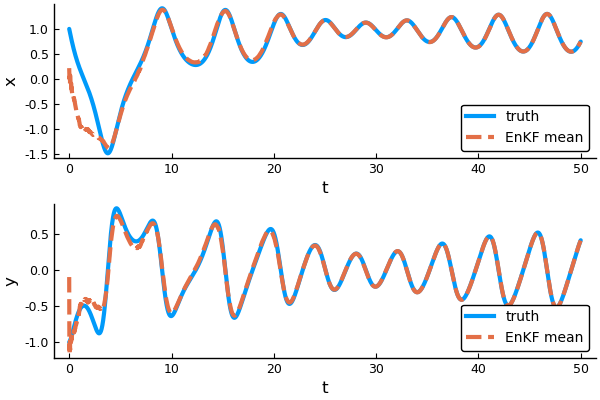

In [138]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)

plt = plot(layout = (2, 1), legend = :bottomright)
plot!(plt[1], T, s[1,1:end], linewidth = 3, label = "truth")
plot!(plt[1], Tsub, ŝ[1,1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)

plot!(plt[2], T, s[2,1:end], linewidth = 3, label = "truth")
plot!(plt[2], Tsub, ŝ[2,1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash)

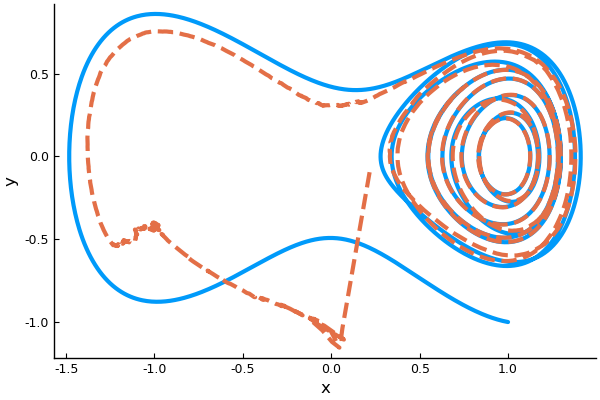

In [139]:
plot(s[1,:], s[2,:], linewidth = 3, label = "truth", legend = true)
plot!(ŝ[1,1:end-1], ŝ[2,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "x", 
    ylabel = "y", linestyle = :dash, legend = false)#:bottomleft)

Plot diagonal components of the *a posteriori* covariance

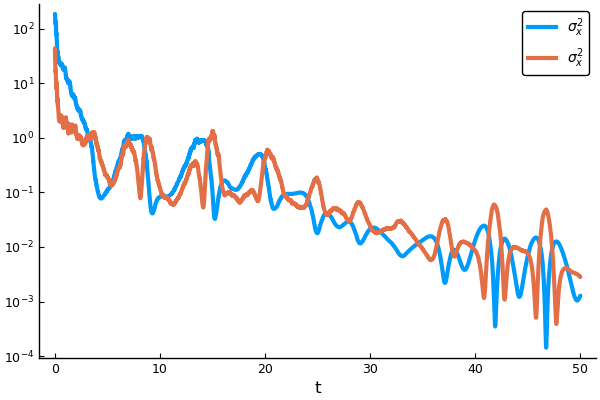

In [145]:
plot(Tsub, map(covs) do P  
        P[1,1]+ eps() end, yscale = :log10, linewidth = 3, label = L"\sigma^2_{x}")
plot!(Tsub, map(covs) do P
        P[2,2]+ eps() end, yscale = :log10, linewidth = 3, xlabel = "t", label = L"\sigma^2_{\dot{x}}")